In [4]:
# !pip install attention

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.datasets import reuters, imdb
from sklearn.model_selection import train_test_split

from attention import Attention

RNN(순환신경망)

In [6]:
# 하이퍼 파라미터 설정
vocab_size = 10000 # 어휘 사전 크기
max_len = 200 # sequence 최대 길이
embedding_dim = 32 # 임베딩 (문자 >> 숫자) 차원
batch_size = 64 # 배치 크기
epochs = 5 # 학습 횟수

# 데이터 가져오기
(x_train, y_train), (x_test, y_test) = \
imdb.load_data(num_words=vocab_size)

17464789/17464789 [==============================] - 1s 0us/step


In [7]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [8]:
print(y_train[:10])

[1 0 0 1 0 0 1 0 1 0]


In [9]:
sequence.pad_sequences(x_train, maxlen=50)

array([[2071,   56,   26, ...,   19,  178,   32],
       [8255,    5,    2, ...,   16,  145,   95],
       [ 215,   28,  610, ...,    7,  129,  113],
       ...,
       [   4,   65,  496, ...,    4, 3586,    2],
       [  13,   18,   31, ...,   12,    9,   23],
       [7585,    8, 2197, ...,  204,  131,    9]], dtype=int32)

In [10]:
sequence.pad_sequences(x_train, maxlen=200)
# 0의 의미? zero-padding
# >> (입력으로 들어갈 단어의 전체 길이를 최대 길이인 200으로 맞추기 위함)

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]], dtype=int32)

In [11]:
# sequence padding
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

In [12]:
type(x_train)

numpy.ndarray

In [13]:
# 모델생성(rnn)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# return_sequences=False
'''
RNN 계층 전체 sequence 대한 학습을 수행, 처리한 후 time step 출력만 다음 층 (next layer) 전달
즉, 최종상태 (context vector 문맥 벡터) 기반으로 분류

이와는 달리
return_sequences=True 일 경우, 각 time step 출력 반환, 이를 다음 rnn계층의 입력으로 사용
rnn 계층을 여러 개 쌓을 때 이를 활용
(hint)
model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=False))
'''

'\nRNN 계층 전체 sequence 대한 학습을 수행, 처리한 후 time step 출력만 다음 층 (next layer) 전달\n즉, 최종상태 (context vector 문맥 벡터) 기반으로 분류\n\n이와는 달리\nreturn_sequences=True 일 경우, 각 time step 출력 반환, 이를 다음 rnn계층의 입력으로 사용\nrnn 계층을 여러 개 쌓을 때 이를 활용\n(hint)\nmodel.add(SimpleRNN(64, return_sequences=True))\nmodel.add(SimpleRNN(64, return_sequences=False))\n'

In [14]:
# 모델 컴파일(학습 환경 설정)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# 학습의 조기 중단 설정
earlystopping_callback= EarlyStopping(monitor='val_loss', patience=5)

In [16]:
# 모델 학습(fit / train data만)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                    callbacks=[earlystopping_callback])

Epoch 1/5
391/391 [==============================] - 118s 293ms/step - loss: 0.6374 - accuracy: 0.6313 - val_loss: 0.4920 - val_accuracy: 0.7701
Epoch 2/5
391/391 [==============================] - 90s 230ms/step - loss: 0.4522 - accuracy: 0.7924 - val_loss: 0.6790 - val_accuracy: 0.7005
Epoch 3/5
391/391 [==============================] - 89s 227ms/step - loss: 0.3915 - accuracy: 0.8324 - val_loss: 0.4342 - val_accuracy: 0.8077
Epoch 4/5
391/391 [==============================] - 77s 198ms/step - loss: 0.4533 - accuracy: 0.7801 - val_loss: 0.6437 - val_accuracy: 0.6113
Epoch 5/5
391/391 [==============================] - 80s 204ms/step - loss: 0.5478 - accuracy: 0.7156 - val_loss: 0.5948 - val_accuracy: 0.6793


In [17]:
# 결과 출력
print('텍스트 정확도: %.4f'%(model.evaluate(x_test,y_test)[1]))

782/782 [==============================] - 15s 19ms/step - loss: 0.5948 - accuracy: 0.6793
텍스트 정확도: 0.6793


LSTM

In [18]:
# 데이터 가져오기
(x_train, y_train), (x_test, y_test) = \
reuters.load_data(num_words=1000, test_split=0.2)
# num_words=1000 빈도수가 큰 것을 기준으로 구분된 1000개, train/test 비율 80% : 20%

2110848/2110848 [==============================] - 0s 0us/step


In [19]:
print(x_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [20]:
type(x_train[0])

list

In [21]:
# 데이터 확인
category = np.max(y_train) + 1
# index 가 0 부터 시작하니까
print(category, '종류')
print(len(x_train), '학습용 뉴스 기사')
print(len(x_test), '테스트용 뉴스 기사')

46 종류
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사


In [22]:
x_train = sequence.pad_sequences(x_train, maxlen=100)
x_test = sequence.pad_sequences(x_test, maxlen=100)

In [23]:
print(x_train[0])
# 0 : zero padding

[  0   0   0   0   0   0   0   0   0   0   0   0   0   1   2   2   8  43
  10 447   5  25 207 270   5   2 111  16 369 186  90  67   7  89   5  19
 102   6  19 124  15  90  67  84  22 482  26   7  48   4  49   8 864  39
 209 154   6 151   6  83  11  15  22 155  11  15   7  48   9   2   2 504
   6 258   6 272  11  15  22 134  44  11  15  16   8 197   2  90  67  52
  29 209  30  32 132   6 109  15  17  12]


In [24]:
print(y_train[:10])

[ 3  4  3  4  4  4  4  3  3 16]


In [25]:
# one-hot encoding 전처리

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [26]:
print(y_train[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [27]:
# 모델 구조
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
# LSTM 은 tanh 를 좋아해
model.add(Dense(46, activation='softmax'))
# why softmax ?? >> 46카테고리로 분류 (다중 분류)

In [28]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
# 학습의 조기 중단 설정
earlystopping_callback= EarlyStopping(monitor='val_loss', patience=5)

# 모델 실행
history = model.fit(x_train, y_train, batch_size=20, epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[earlystopping_callback])

Epoch 1/100
450/450 [==============================] - 27s 54ms/step - loss: 2.2006 - accuracy: 0.4336 - val_loss: 1.8307 - val_accuracy: 0.5383
Epoch 2/100
450/450 [==============================] - 7s 16ms/step - loss: 1.7656 - accuracy: 0.5455 - val_loss: 1.6948 - val_accuracy: 0.5699
Epoch 3/100
450/450 [==============================] - 5s 12ms/step - loss: 1.6161 - accuracy: 0.5828 - val_loss: 1.5778 - val_accuracy: 0.6064
Epoch 4/100
450/450 [==============================] - 6s 13ms/step - loss: 1.4480 - accuracy: 0.6276 - val_loss: 1.4363 - val_accuracy: 0.6451
Epoch 5/100
450/450 [==============================] - 6s 12ms/step - loss: 1.3054 - accuracy: 0.6669 - val_loss: 1.3197 - val_accuracy: 0.6661
Epoch 6/100
450/450 [==============================] - 4s 10ms/step - loss: 1.1654 - accuracy: 0.7083 - val_loss: 1.2442 - val_accuracy: 0.6861
Epoch 7/100
450/450 [==============================] - 5s 11ms/step - loss: 1.0699 - accuracy: 0.7300 - val_loss: 1.2027 - val_accuracy

In [30]:
# 결과 출력
print('텍스트 정확도: %.4f'%(model.evaluate(x_test,y_test)[1]))

71/71 [==============================] - 0s 4ms/step - loss: 1.2546 - accuracy: 0.7217
텍스트 정확도: 0.7217


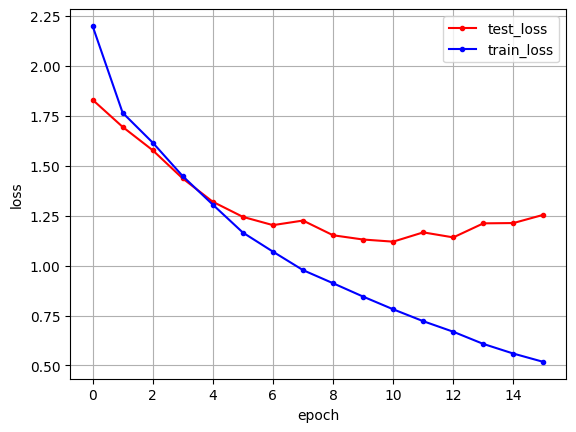

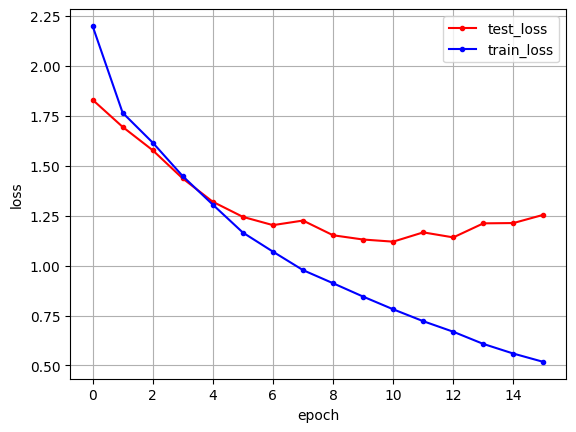

In [31]:
# 데이터 시각화
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='test_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show(0)

LSTM / CNN 조합 >> IMDB 영화 리뷰 분류

In [32]:
# 데이터 불러오기

(x_train, y_train), (x_test, y_test) = \
imdb.load_data(num_words=5000)

In [33]:
x_train = sequence.pad_sequences(x_train, maxlen=500)
x_test = sequence.pad_sequences(x_test, maxlen=500)

In [34]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [35]:
# 모델 구조 설정
model = Sequential()
model.add(Embedding(5000, 100))
# Embedding(5000, 100) vacab_size = 5000, 각 단어를 나타내는 임베딩 벡터 차원
model.add(Dropout(0.5))
# 전체 딥러닝 네크워크의 50% 비활성화
model.add(Conv1D(64, 5, padding='valid', activation='relu'))
# 64개 필터 개수, 5 필터 크기,
# padding='valid zero padding 없이 convolution 통과한 값 출력 값 사용

# CNN (Conv1D)
model.add(MaxPooling1D(pool_size=4))
# pool_size=4 >> 4개 값 중 최대값 추출

model.add(LSTM(50))
# LSTM 50 unit 개수
# LSTM
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         500000    
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 64)          0         
 D)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 50)                23000     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                      

In [ ]:
'''
(1) embedding_2 (Embedding) 5000(vacab_size) * 100(차원 수) = 500000
(2) dropout_1 (Dropout) 네트워크만 임의로 비활성화 >> 학습 가능한 파라미터 0
(3) conv1d_1 (Conv1D) 5(커널 크기) * 100(입력 채널 수) * 64(필터 수) + 64(bias) = 32064
(4) max_pooling1d_1 (MaxPooling1D)  특징 추출을 위해 큰 값만 추출 >> 학습 가능한 파라미터 0
(5) lstm_1 (LSTM) 4 * (50(유닛 수) + 64(입력 특징 수) +1) * 50 = 23000
유닛 개수 50
- unit : LSTM cell 의 개수
입력 특징 수 64
- LSTM cell에 입력되는 데이터 차원 수

파라미터 수
4 * ((입력특징 수 + 유닛 개수 + 1) * 유닛 개수)
- why? 4를 곱해요?
>> LSTM 이 4개의 gate(forget gate, input gate, output gate cell state)를 가짐
4 * (50+64+1) * 50 = 23000
(6) dense_1 (Dense) 50 * 1 + 1(bias) = 51
'''

In [37]:
64 * 5 * 100 + 64

32064

In [40]:
4 * (50+64+1) * 50

23000

In [42]:
# 모델 실행
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# 조기 중단 실행
earlystopping_callback= EarlyStopping(monitor='val_loss', patience=5)

In [44]:
history = model.fit(x_train, y_train, batch_size=64, epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[earlystopping_callback])

Epoch 1/100
391/391 [==============================] - 61s 143ms/step - loss: 0.3944 - accuracy: 0.8143 - val_loss: 0.3002 - val_accuracy: 0.8795
Epoch 2/100
391/391 [==============================] - 29s 74ms/step - loss: 0.2410 - accuracy: 0.9058 - val_loss: 0.2716 - val_accuracy: 0.8871
Epoch 3/100
391/391 [==============================] - 15s 37ms/step - loss: 0.1905 - accuracy: 0.9281 - val_loss: 0.2989 - val_accuracy: 0.8838
Epoch 4/100
391/391 [==============================] - 13s 34ms/step - loss: 0.1603 - accuracy: 0.9411 - val_loss: 0.2920 - val_accuracy: 0.8872
Epoch 5/100
391/391 [==============================] - 11s 29ms/step - loss: 0.1338 - accuracy: 0.9510 - val_loss: 0.3060 - val_accuracy: 0.8860
Epoch 6/100
391/391 [==============================] - 9s 24ms/step - loss: 0.1134 - accuracy: 0.9604 - val_loss: 0.3491 - val_accuracy: 0.8835
Epoch 7/100
391/391 [==============================] - 11s 27ms/step - loss: 0.0946 - accuracy: 0.9673 - val_loss: 0.3678 - val_ac

In [45]:
# 테스트 정확도 출력
print('테스트 정확도: %.4f'%(model.evaluate(x_test,y_test)[1]))

782/782 [==============================] - 4s 5ms/step - loss: 0.3678 - accuracy: 0.8830
테스트 정확도: 0.8830


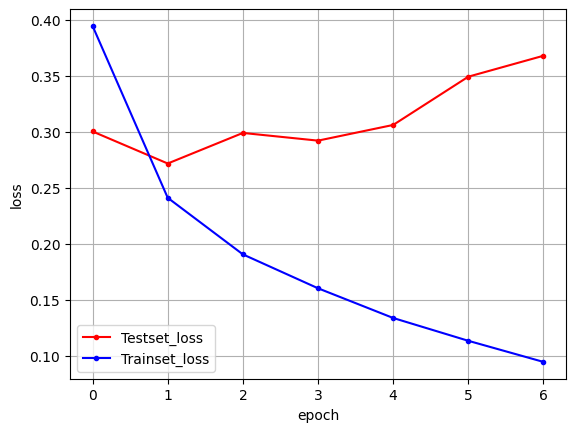

In [48]:
# 데이터 시각화
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

어텐션 신경망

In [49]:
# !pip install attention

In [51]:
# 모델 구조 재설계 (attention 활용)

# 모델 구조 설정
model = Sequential()
model.add(Embedding(5000, 500))
# Embedding(5000, 500) vacab_size = 5000, 각 단어를 나타내는 임베딩 벡터 차원
model.add(Dropout(0.5))
# 전체 딥러닝 네크워크의 50% 비활성화
model.add(LSTM(64, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 500)         2500000   
                                                                 
 dropout_3 (Dropout)         (None, None, 500)         0         
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          144640    
                                                                 
 attention_1 (Attention)     (None, 128)               20480     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2665249 (10.17 MB)
Trainable params: 266

In [52]:
# 모델 실행 옵션 설정
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# 조기종료 옵션 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
# 모델 실행
history = model.fit(x_train,y_train, batch_size=40, epochs=200, validation_data=(x_test, y_test),
          callbacks=[early_stopping_callback])
#테스트 정확도 출력
print("\n 테스트 정확도: %.4f" % (model.evaluate(x_test, y_test)[1]))

Epoch 1/200
625/625 [==============================] - 79s 120ms/step - loss: 0.3831 - accuracy: 0.8241 - val_loss: 0.2692 - val_accuracy: 0.8880
Epoch 2/200
625/625 [==============================] - 35s 56ms/step - loss: 0.2231 - accuracy: 0.9124 - val_loss: 0.2743 - val_accuracy: 0.8875
Epoch 3/200
625/625 [==============================] - 27s 43ms/step - loss: 0.1643 - accuracy: 0.9361 - val_loss: 0.2929 - val_accuracy: 0.8841
Epoch 4/200
625/625 [==============================] - 24s 39ms/step - loss: 0.1199 - accuracy: 0.9537 - val_loss: 0.3350 - val_accuracy: 0.8822
Epoch 5/200
625/625 [==============================] - 23s 37ms/step - loss: 0.0840 - accuracy: 0.9690 - val_loss: 0.4106 - val_accuracy: 0.8797
Epoch 6/200
782/782 [==============================] - 8s 10ms/step - loss: 0.4586 - accuracy: 0.8770

 테스트 정확도: 0.8770


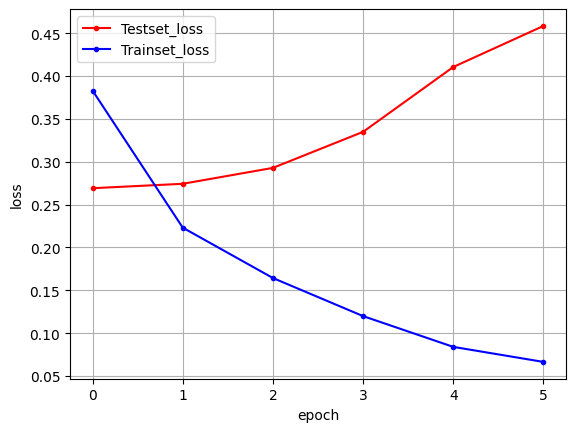

In [53]:
# 데이터 시각화
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()